# Gesture Recognition
### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each video is a sequence of 30 frames of image and each gesture corresponds to a below specific command:

- **Thumbs Up**   : Increase the volume.
- **Thumbs Down** : Decrease the volume.
- **Left Swipe**  : Slide the videos backward.
- **Right Swipe** : Slide the videos forward.
- **Stop**        : Stop the video.


 
### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

#### In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Authors:
* Sidhartha Sankar Mahapatro
* S S B Phani Pradeep Miriyala

In [1]:
# Display GPU information on VM.
!nvidia-smi

Fri Feb  5 05:27:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    81W / 149W |      0MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
# Importing warnings to ignore warnings.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing image libraries
import numpy as np
from scipy.misc import imread, imresize
from PIL import Image
import cv2
# Importing OS library to parse paths of images.
import os
# To create dynamic model files from 
import datetime
# Importing randomg library for setting the seed before building models.
import random as rn

In [3]:
# Defining project folder where all images are stored.
project_folder='Project_data'

In [4]:
# Define a dictionary object to store all models.
# All models will be stored in a dictionary with key being the model name.
models = {}

# Generator
A generator class will be used to generate training data and validation data for use tensorflow models. The generator will yield the data per the current batch.

The generator will 
- Read in images as specified by indices of frames to be used for training and validation
- Performs image normalization and augmentation in two levels.
- A level 1 augmentation does warp affine with angle of 10 degrees.
- A level 2 augmentation does warp affine and image rotation by 10 degrees.

In [5]:
class Generator:
    '''Generator class for creating objects to use with Keras Sequential model'''
    def __init__(self, root_folder, gen_type, frames_list, batch_size=5, image_height=160, image_width=160, 
                 augment_level=0):
        ''' 
        Constructor for the class.
        root_folder is root folder where training and validation data are stored as sub-folders.
        gen_type is type of generator. It can be either "train" or "val". Any other values are not supported.
        frames_list is list of frame indices from each video.
        batch_size is size of batch to be used for training and validation.
        image_height is desired height of image for model.
        image_width is desired width of image for model.
        num_classes is number of classes for training.
        augment_level is level of augmentation needed. 
                    Level 0 - No augmentation,
                    Level 1 - Augmentation with wrap affine transformation
                    Level 2 - Augmentation with wrap affine transformation and rotation of image.
        '''
        if gen_type == 'train':
            self.src_path = os.path.join(root_folder,'train')
            self.csv_file = os.path.join(root_folder,'train.csv')
        elif gen_type == 'val':
            self.src_path = os.path.join(root_folder,'val')
            self.csv_file = os.path.join(root_folder,'val.csv')
        
        self.folders = np.random.permutation(open(self.csv_file).readlines())        
        self.num_sequences = len(self.folders)
        self.num_channels = 3 # All images are RGB.
        self.batch_size = batch_size
        self.num_batches = self.num_sequences//self.batch_size
        
        self.image_height = image_height
        self.image_width = image_width
        self.num_classes = 5
        
        self.frames_list = frames_list
        self.total_frames = len(self.frames_list)
        self.augment_level = augment_level
        self.steps = self.__get_steps()
        
    def __get_steps(self):
        '''
        Get number of steps required based on batch size of object.
        '''
        if self.num_sequences%self.batch_size==0:
            return self.num_sequences//self.batch_size
        else:
            return 1 + (self.num_sequences//self.batch_size)
        
    def __apply_augmentation(self,frame):
        '''
        Apply augmentation on image frame. 
        Augmentation applied is based on level of augmentation set during initialization of object.
        '''
        ang = 10
        rang = 10
        if self.augment_level<1: 
            return None
        # Horizontal or Vertical flipping can't be applied.
        # Both flippings will negatively impact training data and corresponding labels.
        shifted = cv2.warpAffine(frame, np.float32([[1, 0, np.random.randint(-ang,ang)],
                                                    [0, 1, np.random.randint(-ang,ang)]]), 
                                 (frame.shape[1], frame.shape[0]))
        # Converting/shifting to Gray Scale Image form RGB
        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
        # Setting up the co-ordinate
        x0, y0 = np.argwhere(gray > 0).min(axis=0)
        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
        # cropping the images to have the targeted gestures and remove the noise from the images.
        cropped = shifted[x0:x1,y0:y1,:]
        image_resized = imresize(cropped,(self.image_height,self.image_width,3))
        if self.augment_level>1:
            # Configuring 2D matrix for ration matrix
            M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                        np.random.randint(-rang,rang), 1.0)
            # Rotating the image using warpAffine method based on rotation matrix
            image_resized = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
        image_resized[:,:,0] = image_resized[:,:,0]/255
        image_resized[:,:,1] = image_resized[:,:,1]/255
        image_resized[:,:,2] = image_resized[:,:,2]/255
        return image_resized[:,:,0],image_resized[:,:,1],image_resized[:,:,2]
        
    def __gen_batch_data(self, batch):
        '''
        Collect data from current batch and associate them with respective labels.
        '''
        # Formulating batch data based on frame count and batch size
        if batch == self.num_batches:
            b_size = self.num_sequences%self.batch_size
        else:
            b_size = self.batch_size
        
        batch_offset = batch * self.batch_size
        
        batch_data = np.zeros((b_size,self.total_frames,self.image_width,self.image_height,3))

        # batch_labels is the one hot representation of the output
        batch_labels = np.zeros((b_size,self.num_classes)) 

        if self.augment_level > 0 :
            batch_data_aug = np.zeros((b_size,self.total_frames,self.image_width,self.image_height,3))

        # iterate over the batch_size
        for fidx in range(b_size):
            fold_idx = fidx + batch_offset 
            vid_folder = os.path.join(self.src_path,self.folders[fold_idx].split(';')[0])
            # read all the images in the folder
            frames = os.listdir(vid_folder) 

            #  Iterate over the frames/images of a folder to read them in
            for idx,item in enumerate(self.frames_list):
                frame = np.asarray(Image.open(os.path.join(vid_folder,frames[item])))
                frame_resized = imresize(frame,(self.image_height,self.image_width,3))
                # Normalise and feed in the image as per RGB channels
                batch_data[fidx,idx,:,:,0] = frame_resized[:,:,0]/255 
                batch_data[fidx,idx,:,:,1] = frame_resized[:,:,1]/255 
                batch_data[fidx,idx,:,:,2] = frame_resized[:,:,2]/255 

                # Applying augmentation to convert into gray scale and crop all the image into a generic size 
                # and remove noise
                if self.augment_level>0:
                    batch_data_aug[fidx,idx,:,:,0],batch_data_aug[fidx,idx,:,:,1],batch_data_aug[fidx,idx,:,:,2] = self.__apply_augmentation(frame)

            batch_labels[fidx, int(self.folders[fold_idx].strip().split(';')[2])] = 1

        # If augmented then we can concatenated both batch and augment data
        if self.augment_level>0:
            batch_data = np.concatenate([batch_data,batch_data_aug])
            batch_labels = np.concatenate([batch_labels,batch_labels])

        return batch_data,batch_labels
    
    def generator(self):
        '''Generator function for use by sequential models'''
        while True:
            # Iterate over the number of batches
            for batch in range(self.num_batches):
                yield self.__gen_batch_data(batch)
            
            # Code for the remaining data points which are left after full batches
            if self.num_sequences%self.batch_size != 0:
                yield self.__gen_batch_data(self.num_batches)

## Model Building
We will define following models
- 3D models with convolution
- Time Distributed 2D models with convolution, LSTM and GRU
- Transfer learning using Mobilenet with LSTM, GRU . (Mobilenet is chosen for it's small size and robusness)

### Importing packages for building the DNN models

In [6]:
# Importing Tensorflow and Keras packages
from keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence

# Setting random seed to make results repeatable.
rn.seed(30)
np.random.seed(30)
tf.set_random_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

Using TensorFlow backend.


In [7]:
# Importing plotting libraries so that we can generate plots for model history from epochs ran.
import matplotlib.pyplot as plt
% matplotlib inline

### Plotting function for plotting loss and accuracy of the model

In [8]:
def plot_metrics(mdl, metric='categorical_accuracy', loss='loss', title=''):
    '''Create a plot of given metric and loss function from the model history with a given title.'''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(mdl.history.history[loss])   
    axes[0].plot(mdl.history.history[f'val_{loss}'])
    axes[0].legend([loss,f'val_{loss}'])
    axes[0].set_title(loss)
    axes[0].set_xlabel('Epochs')

    axes[1].plot(mdl.history.history[metric])   
    axes[1].plot(mdl.history.history[f'val_{metric}'])
    axes[1].legend([metric,f'val_{metric}'])
    axes[1].set_title(metric)
    axes[1].set_xlabel('Epochs')

    plt.suptitle(title)

    plt.show()

### Model callbacks method to save result.
Building Deep Learning models without callbacks is like driving a car with no functioning brakes. A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

Callback function should be defined to automate some tasks after every training/epoch that help you have controls over the training process. This includes stopping training when you reach a certain accuracy/loss score, saving your model as a checkpoint after each successful epoch, adjusting the learning rates over time, and more.

Below are the functions used in the below callback function:

  * EarlyStopping: The EarlyStoppingfunction has various metrics/arguments that you can modify to set up when the training process should stop.
  * ModelCheckpoint: Define model path to save last updated state.
  * ReduceLROnPlateau: Role is to reduce the learning rate when a metric has stopped improving. 

In [9]:
def callbacks(monitor='val_loss'):
    '''Returns list of callbacks for model construction. The list contains
        a) Model Check point object. Saves all models.
        b) Learning Rate Callback object to control learning rate with patience of 4.
        c) Eearly stopping callback with patience of 10.
    '''
    # Creating model name concatenating model_init with datatime stamp
    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'   

    if not os.path.exists(model_name): os.mkdir(model_name)

    # Concatenating model name with various hyperparameter values to track.
    model_name = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}'
    filepath = model_name + '-{val_categorical_accuracy:.5f}.h5'

    # Creating checkpoint to save parameters like weight and bias to increase the performance
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=False, 
                                 save_weights_only=False, mode='new', period=1)
    # Using Reduce Learning Rate on Plateau to monitor value loss while training the model and provide the statistics
    LR = ReduceLROnPlateau(monitor = monitor, factor = 0.2, verbose = 1, patience = 4)

    # Early stopping mechanism will help to stop the training process if no improvement found in training accuracy.
    earlystop = EarlyStopping(monitor = monitor, min_delta = 0, patience = 10, verbose = 1)

    return [checkpoint, LR, earlystop]

## 3D Models
``Convolutional neural networks (CNNs)`` are a type of deep model that can act directly on the raw inputs. This model extracts features from both the spatial and the temporal dimensions by performing 3D convolutions, thereby capturing the motion information encoded in multiple adjacent frames.
 * 3D Convolution is a type of convolution where the kernel slides in 3 dimensions as opposed to 2 dimensions with 2D convolutions. 
 * One example use case is medical imaging where a model is constructed using 3D image slices. Additionally video based data has an additional temporal dimension over images making it suitable for this module.

In [11]:
def run_3d_model(batch_size, frames, img_height, img_width, callbacks_list, mdl_fcn, optimizer, 
                 num_epochs = 15, dense_neurons = 64, dropout_val = 0.25, augment_level = 0, nworkers = 1):
    '''Construct and run a 3D model. Returns the 3D model after completion of fitting data.
    batch_size: Size of batch for training and validation
    frames: List of frame indices to be used by model
    img_height, img_width: Image dimensions for resizing
    callbacks_list: List of callbacks for model
    mdl_fcn: Model function to build 3D model. Must be one of 3D functions defined under "Models" class
    optimizer: Optimizer to be used by model
    num_epochs: Number of epochs by model
    dense_neurons: Number of dense neurons
    dropout_val: Dropout value in 3D model
    augment_level: Augmentation level to be applied on generator. Must be one of {0,1,2}
    nworkers: Number of workers to be configured for fit_generator method.
    '''
    # Configuring train and validation generator from get_generator function based on batch size and image properties.
    train_generator = Generator(project_folder, 'train', frames, batch_size, img_height, img_width, augment_level)
    val_generator = Generator(project_folder,'val', frames, batch_size, img_height, img_width, augment_level)
        
    model = mdl_fcn(len(frames), img_height, img_width, optimizer, dense_neurons, dropout_val, True)
    
    model.fit_generator(train_generator.generator(), steps_per_epoch=train_generator.steps, epochs=num_epochs, 
                        verbose=1, validation_data=val_generator.generator(), validation_steps=val_generator.steps, 
                        class_weight=None, workers=nworkers, initial_epoch=0, callbacks = callbacks_list)
    
    return model

### Model 1 - Basic 3D Model definition

In [12]:
def m3d(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Creates 3D model.
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for all convolution layers with pooling sizes of 2x2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Fourth convolutional layer
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 1 - 3D basic model without augmentation

In [13]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 160, 160
# Batch size used for training and validation
batch_size = 40
# Number of epochs to run.
num_epochs = 20
# Title of the model
mdl_title = '3D Basic model without augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), m3d,
                                             optimizers.Adam(), num_epochs, augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 80, 80, 32)     128       
__________

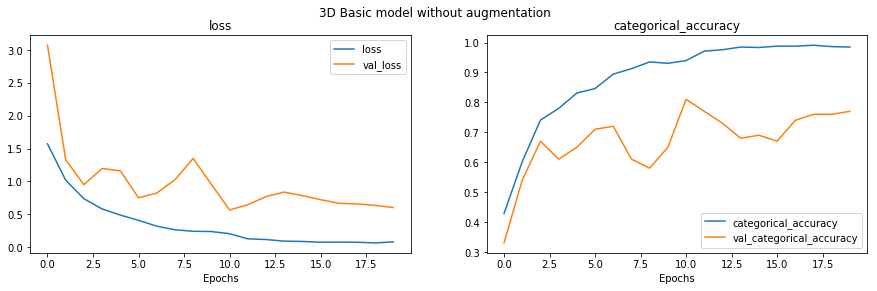

In [14]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Accuracy difference between training and validation is almost 20% (98 - 77)
* Validation accuracy is not consistently improving although training accuracy reached maximum
* Thus, this is clearly overfitting
* Thus, this model will not be considered

### Experiment 2 - Basic 3D Model with augmentation level 1

In [15]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 40
# Number of epochs to run.
num_epochs = 20
# Title of the model
mdl_title = '3D Basic model with level 1 augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), m3d,
                                             optimizers.Adam(), num_epochs, augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 32)     128       
__________


Epoch 00017: saving model to model_init_2021-02-0505_43_41.784205/model-00017-0.77292-0.69683-1.19480-0.55500.h5
Epoch 18/20
17/17 [==============================] - 79s 5s/step - loss: 0.7541 - categorical_accuracy: 0.7014 - val_loss: 1.2014 - val_categorical_accuracy: 0.5500

Epoch 00018: saving model to model_init_2021-02-0505_43_41.784205/model-00018-0.76124-0.69834-1.20138-0.55000.h5
Epoch 19/20
17/17 [==============================] - 79s 5s/step - loss: 0.7071 - categorical_accuracy: 0.7200 - val_loss: 1.2823 - val_categorical_accuracy: 0.5200

Epoch 00019: saving model to model_init_2021-02-0505_43_41.784205/model-00019-0.71176-0.71795-1.28226-0.52000.h5

Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 20/20
17/17 [==============================] - 79s 5s/step - loss: 0.6967 - categorical_accuracy: 0.7290 - val_loss: 1.2391 - val_categorical_accuracy: 0.5550

Epoch 00020: saving model to model_init_2021-02-0505_43_41.784205/model-00020-0.

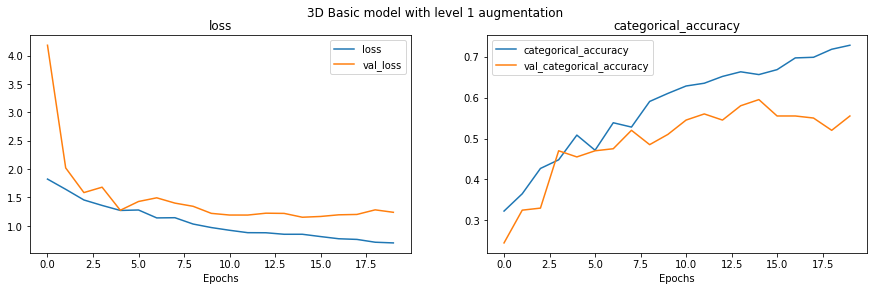

In [16]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* There is no drastic increase in training accuracy. Always below 75%
* The validation accuracy has increased very slow and is always below 60%.
* Validation loss is not consistent when compared to training loss.
* The scores are low. Thus this model is not considered.

### Experiment 3 - Basic 3D model with augmentation level 2

In [17]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 40
# Number of epochs to run.
num_epochs = 20
# Title of the model
mdl_title = '3D Basic model with level 2 augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), m3d,
                                             optimizers.Adam(), num_epochs, augment_level = 2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 32)     128       
__________


Epoch 00017: saving model to model_init_2021-02-0506_10_38.826704/model-00017-0.68469-0.73379-1.42330-0.49000.h5
Epoch 18/20
17/17 [==============================] - 82s 5s/step - loss: 0.6354 - categorical_accuracy: 0.7534 - val_loss: 1.2329 - val_categorical_accuracy: 0.5150

Epoch 00018: saving model to model_init_2021-02-0506_10_38.826704/model-00018-0.63686-0.75113-1.23289-0.51500.h5
Epoch 19/20
17/17 [==============================] - 82s 5s/step - loss: 0.6501 - categorical_accuracy: 0.7400 - val_loss: 1.2271 - val_categorical_accuracy: 0.5150

Epoch 00019: saving model to model_init_2021-02-0506_10_38.826704/model-00019-0.64846-0.74208-1.22715-0.51500.h5

Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 20/20
17/17 [==============================] - 82s 5s/step - loss: 0.6104 - categorical_accuracy: 0.7713 - val_loss: 1.2020 - val_categorical_accuracy: 0.5100

Epoch 00020: saving model to model_init_2021-02-0506_10_38.826704/model-00020-0.

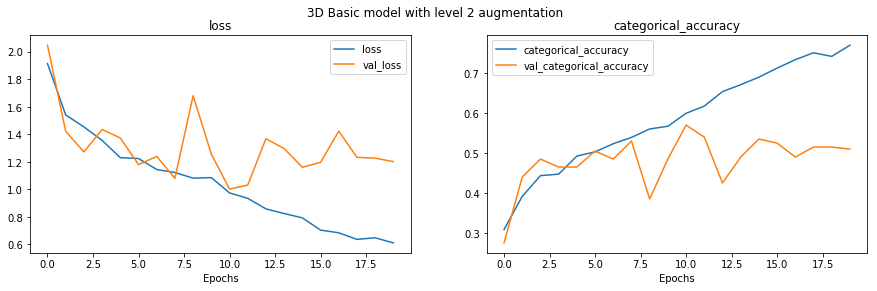

In [18]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* There is no drastic increase in training accuracy and is always below 80%.
* The validation accuracy has increased very slow and is always below 50% and flat after epoch 12.
* Validation loss is not consistent when compared to training loss.
* Thus, we will not consider augmentation level 2 going forward with other models.

### Model 2 - 3D Model with multiple parameters

In [19]:
def m3d_params(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 2x2x2 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 4 - 3D Model with reducing filter size and without augmentation

In [20]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 180, 180
# Batch size used for training and validation
batch_size = 30
# Number of epochs to run.
num_epochs = 25
# Learning rate
lr = 0.0002
# Title of the model
mdl_title = '3D Model with reducing filter size and without augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params, optimizers.Adam(lr=lr), num_epochs, 
                                                        dense_neurons = 256, dropout_val = 0.5, augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 180, 180, 16)  400       
_________________________________________________________________
activation_13 (Activation)   (None, 16, 180, 180, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 180, 180, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 90, 90, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 90, 90, 32)     4128      
_________________________________________________________________
activation_14 (Activation)   (None, 8, 90, 90, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 90, 90, 32)     128       
__________


Epoch 00017: saving model to model_init_2021-02-0506_38_11.607040/model-00017-0.19122-0.95023-0.55728-0.82000.h5
Epoch 18/25
23/23 [==============================] - 44s 2s/step - loss: 0.1626 - categorical_accuracy: 0.9454 - val_loss: 0.5513 - val_categorical_accuracy: 0.8200

Epoch 00018: saving model to model_init_2021-02-0506_38_11.607040/model-00018-0.13978-0.95626-0.55126-0.82000.h5
Epoch 19/25
23/23 [==============================] - 44s 2s/step - loss: 0.1836 - categorical_accuracy: 0.9477 - val_loss: 0.5504 - val_categorical_accuracy: 0.8100

Epoch 00019: saving model to model_init_2021-02-0506_38_11.607040/model-00019-0.17339-0.94570-0.55044-0.81000.h5
Epoch 20/25
23/23 [==============================] - 44s 2s/step - loss: 0.1744 - categorical_accuracy: 0.9358 - val_loss: 0.5436 - val_categorical_accuracy: 0.8200

Epoch 00020: saving model to model_init_2021-02-0506_38_11.607040/model-00020-0.14185-0.95928-0.54361-0.82000.h5
Epoch 21/25
23/23 [==============================

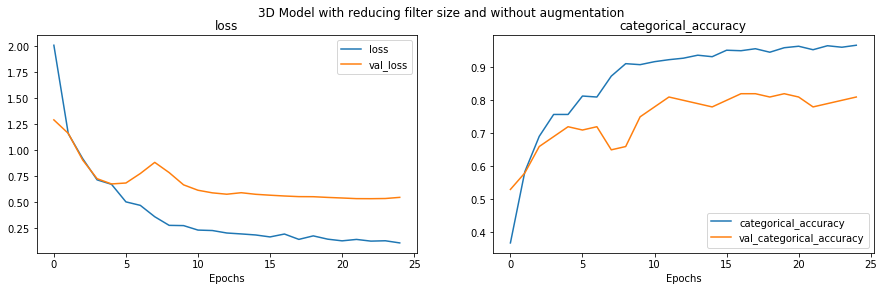

In [21]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Accuracy difference between training and validation is 15% (96 - 81)
* Training and validation accuracy are both stable after 10 epochs.
* Validation loss and training loss are also stable after 10 epochs.
* This model is a good candidate.

### Experiment 5 - 3D model with parameters for dense neurons and dropout with augmentation level 1

In [22]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 30
# Number of epochs to run.
num_epochs = 25
# Learning rate
lr = 0.0002
# Title of the model
mdl_title = '3D Model with reducing filter size and with augmentation level 1'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_params,optimizers.Adam(lr=lr), 
                                 num_epochs, dense_neurons = 256, dropout_val = 0.5, augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 60, 60, 32)     128       
__________

23/23 [==============================] - 79s 3s/step - loss: 0.9048 - categorical_accuracy: 0.6599 - val_loss: 1.0318 - val_categorical_accuracy: 0.6300

Epoch 00018: saving model to model_init_2021-02-0506_56_51.403805/model-00018-0.90333-0.65309-1.03178-0.63000.h5
Epoch 19/25
23/23 [==============================] - 79s 3s/step - loss: 0.8427 - categorical_accuracy: 0.6928 - val_loss: 1.0493 - val_categorical_accuracy: 0.6100

Epoch 00019: saving model to model_init_2021-02-0506_56_51.403805/model-00019-0.85161-0.69382-1.04933-0.61000.h5
Epoch 20/25
23/23 [==============================] - 78s 3s/step - loss: 0.8016 - categorical_accuracy: 0.7037 - val_loss: 1.0350 - val_categorical_accuracy: 0.6400

Epoch 00020: saving model to model_init_2021-02-0506_56_51.403805/model-00020-0.81001-0.70513-1.03501-0.64000.h5

Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
Epoch 21/25
23/23 [==============================] - 79s 3s/step - loss: 0.7551 - categorical

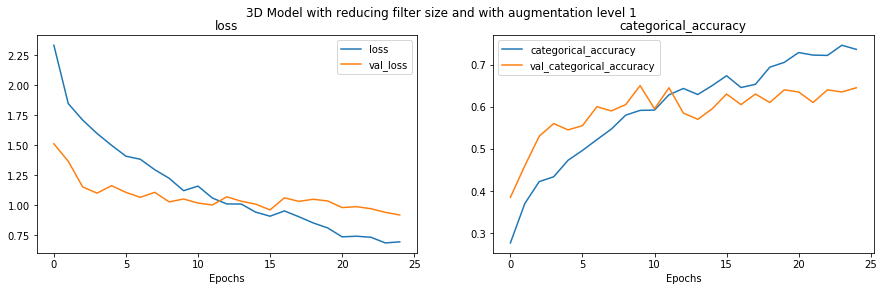

In [23]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Training accuracy is always below 75%. It is also not consistently improving.
* Validation accuracy is not consistent and after 10 epochs, the accuracy is not improving.
* Training loss is decaying fast although validation loss is not decreasing and flat after 10 epochs.

### Model 3 - 3D Model with Reduced parameters

In [24]:
def m3d_redparams_1(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):

    '''
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for first convolution layer and 2x2x2 for remaining layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 6 - 3D model with reduced parameters and without augmentation

In [25]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 160, 160
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Learning rate
lr = 0.0002
# Title of the model
mdl_title = '3D model with reduced parameters and without augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_redparams_1, optimizers.Adam(lr=lr), 
                                 num_epochs, dense_neurons = 128, dropout_val = 0.25, augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_22 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 8, 80, 80, 32)     128       
__________


Epoch 00017: saving model to model_init_2021-02-0507_31_19.457606/model-00017-0.03236-0.99849-0.61440-0.79000.h5
Epoch 18/25
34/34 [==============================] - 40s 1s/step - loss: 0.0465 - categorical_accuracy: 0.9904 - val_loss: 0.6112 - val_categorical_accuracy: 0.8000

Epoch 00018: saving model to model_init_2021-02-0507_31_19.457606/model-00018-0.03442-0.99849-0.61123-0.80000.h5
Epoch 19/25
34/34 [==============================] - 39s 1s/step - loss: 0.0325 - categorical_accuracy: 1.0000 - val_loss: 0.5984 - val_categorical_accuracy: 0.8100

Epoch 00019: saving model to model_init_2021-02-0507_31_19.457606/model-00019-0.02828-1.00000-0.59840-0.81000.h5
Epoch 20/25
34/34 [==============================] - 39s 1s/step - loss: 0.0427 - categorical_accuracy: 0.9875 - val_loss: 0.5937 - val_categorical_accuracy: 0.8000

Epoch 00020: saving model to model_init_2021-02-0507_31_19.457606/model-00020-0.03117-0.99548-0.59374-0.80000.h5
Epoch 21/25
34/34 [==============================

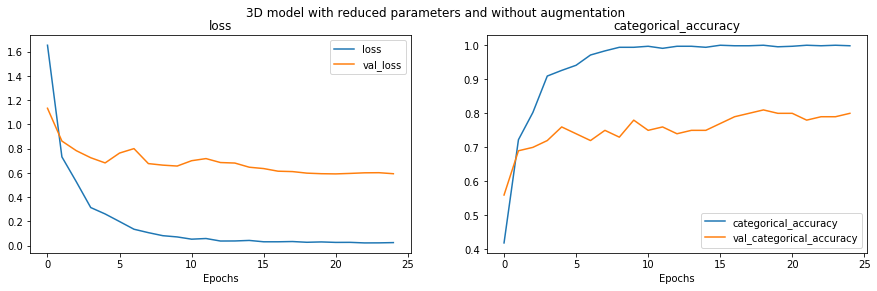

In [26]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Accuracy difference between training dataset and validation dataset is high at 20% (99.85 - 80)
* The model has learned all features from training dataset by end of 6th epoch yet, validation accuracy is not improving consistently.
* This model is overfitting on training data. Thus, this model will not be considered.

### Experiment 7 - 3D model with reduced parameters and with level 1 augmentation

In [27]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Learning rate
lr = 0.0002
# Title of the model
mdl_title = '3D model with reduced parameters and with level 1 augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_redparams_1, optimizers.Adam(lr=lr), 
                                 num_epochs, dense_neurons = 128, dropout_val = 0.25, augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_26 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 60, 60, 32)     128       
__________


Epoch 00017: saving model to model_init_2021-02-0507_48_11.847211/model-00017-0.42298-0.85219-0.98657-0.66000.h5
Epoch 18/25
34/34 [==============================] - 79s 2s/step - loss: 0.3749 - categorical_accuracy: 0.8690 - val_loss: 0.9302 - val_categorical_accuracy: 0.6550

Epoch 00018: saving model to model_init_2021-02-0507_48_11.847211/model-00018-0.38248-0.86576-0.93018-0.65500.h5
Epoch 19/25
34/34 [==============================] - 79s 2s/step - loss: 0.3647 - categorical_accuracy: 0.8867 - val_loss: 0.9551 - val_categorical_accuracy: 0.6350

Epoch 00019: saving model to model_init_2021-02-0507_48_11.847211/model-00019-0.37223-0.88386-0.95512-0.63500.h5
Epoch 20/25
34/34 [==============================] - 79s 2s/step - loss: 0.3606 - categorical_accuracy: 0.8812 - val_loss: 0.9530 - val_categorical_accuracy: 0.6500

Epoch 00020: saving model to model_init_2021-02-0507_48_11.847211/model-00020-0.36469-0.88235-0.95298-0.65000.h5
Epoch 21/25
34/34 [==============================

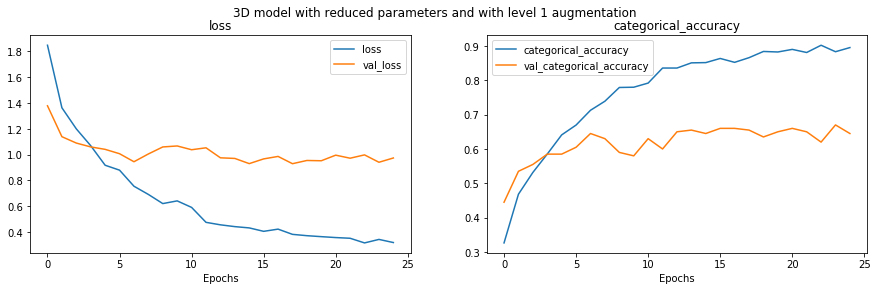

In [28]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Validation accuracy is very low and never crossed 70%.
* Although, training accuracy is increasing and reaching 90%, validation accuracy is almost flat after 5th epoch.
* This model is overfitting and thus this model will not be considered.

### Model 4 - 3D Model with Reduced parameters with change in filter sizes.

In [29]:
def m3d_redparams_2(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for first two convolution layer and 2x2x2 for remaining layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 8 - 3D model with reduced parameters, filter sizes and without augmentation

In [30]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 160, 160
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Learning rate
lr = 0.0002
# Title of the model
mdl_title = '3D model with reduced parameters, filter sizes and without augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_redparams_2, optimizers.Adam(lr=lr), 
                                 num_epochs, dense_neurons = 64, dropout_val = 0.25, augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_30 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 80, 80, 32)     128       
__________

34/34 [==============================] - 39s 1s/step - loss: 0.0761 - categorical_accuracy: 0.9912 - val_loss: 0.5990 - val_categorical_accuracy: 0.8100

Epoch 00018: saving model to model_init_2021-02-0508_21_12.301473/model-00018-0.06896-0.99095-0.59897-0.81000.h5
Epoch 19/25
34/34 [==============================] - 38s 1s/step - loss: 0.0619 - categorical_accuracy: 0.9956 - val_loss: 0.6979 - val_categorical_accuracy: 0.7000

Epoch 00019: saving model to model_init_2021-02-0508_21_12.301473/model-00019-0.06201-0.99548-0.69794-0.70000.h5
Epoch 20/25
34/34 [==============================] - 39s 1s/step - loss: 0.0618 - categorical_accuracy: 0.9912 - val_loss: 0.6555 - val_categorical_accuracy: 0.7800

Epoch 00020: saving model to model_init_2021-02-0508_21_12.301473/model-00020-0.06226-0.99095-0.65546-0.78000.h5
Epoch 21/25
34/34 [==============================] - 38s 1s/step - loss: 0.0526 - categorical_accuracy: 0.9971 - val_loss: 0.6519 - val_categorical_accuracy: 0.7700

Epoch 000

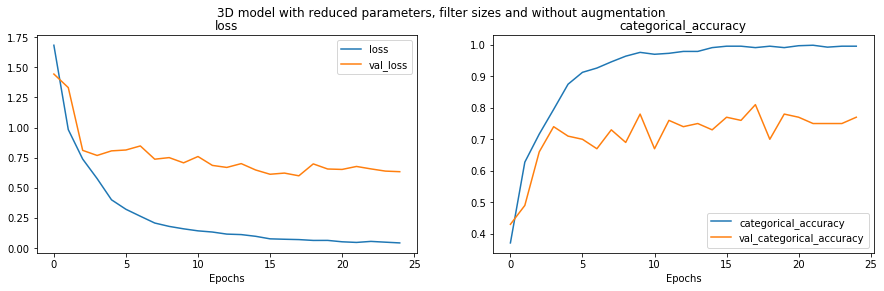

In [31]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Accuracy difference between training and validation is more than 20%. (99.56 - 77)
* Model has learnt all features about training data and its validation accuracy is flat after 5th epoch.
* This model is overfitting and thus, this model will not be considered.

### Experiment 9 - 3D model with reduced parameters, filter sizes and with level 1 augmentation

In [33]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Learning rate
lr = 0.0002
# Title of the model
mdl_title = '3D model with reduced parameters, filter sizes and with augmentation level 1'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_redparams_2, optimizers.Adam(lr=lr), 
                                 num_epochs, dense_neurons = 64, dropout_val = 0.25, augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 8, 60, 60, 32)     128       
__________


Epoch 00017: saving model to model_init_2021-02-0508_55_16.073976/model-00017-0.59313-0.78884-1.05803-0.59000.h5
Epoch 18/25
34/34 [==============================] - 81s 2s/step - loss: 0.5487 - categorical_accuracy: 0.7969 - val_loss: 1.0411 - val_categorical_accuracy: 0.5800

Epoch 00018: saving model to model_init_2021-02-0508_55_16.073976/model-00018-0.55644-0.79186-1.04111-0.58000.h5
Epoch 19/25
34/34 [==============================] - 81s 2s/step - loss: 0.5168 - categorical_accuracy: 0.8065 - val_loss: 1.0017 - val_categorical_accuracy: 0.5950

Epoch 00019: saving model to model_init_2021-02-0508_55_16.073976/model-00019-0.52599-0.80166-1.00173-0.59500.h5

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
Epoch 20/25
34/34 [==============================] - 80s 2s/step - loss: 0.5444 - categorical_accuracy: 0.8286 - val_loss: 1.0481 - val_categorical_accuracy: 0.6050

Epoch 00020: saving model to model_init_2021-02-0508_55_16.073976/model-00020-0.5

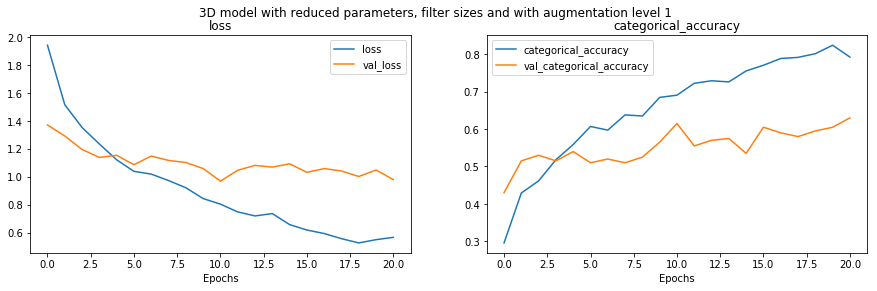

In [34]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Training Accuracy is always below 80%
* Validation accuracy is always below 65%
* After 10 epochs, Validation accuracy and Validation loss are almost flat and not improving.
* This model is not recommended

### Model 5 - 3D Model with multiple convolution layers for one max pooling layer

In [35]:
def m3d_more_layer(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    The model would contain Three sets of (Two Convolution layers and max pooling layer) 
                                        followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 10 - 3D Model with multiple convolution layers for one max pooling layer without augmentation

In [36]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 160, 160
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Title of the model
mdl_title = '3D model with multiple convolution layers for one max pooling layer without augmentation'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_more_layer, optimizers.Adam(), 
                                 num_epochs, dense_neurons = 256, dropout_val = 0.5, augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 16, 160, 160, 16)  6928      
_________________________________________________________________
activation_38 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 80, 80, 16)     0         
__________

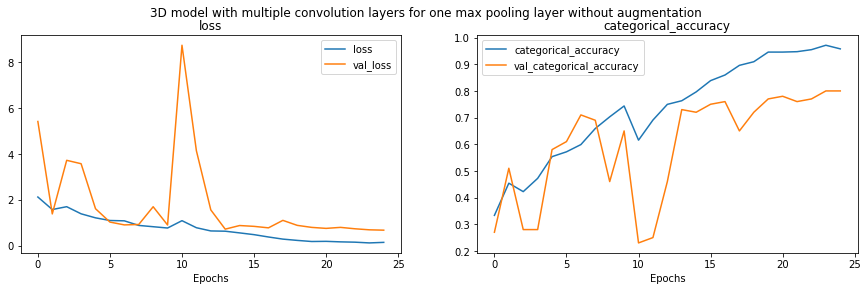

In [37]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Final accuracies are good yet validation accuracy is not stable.
* Validation loss is also not stable.
* This model will not be considered due to unstable behaviour.

### Experiment 11 - 3D Model with multiple convolution layers for one max pooling layer with level 1 augmentation

In [38]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Title of the model
mdl_title = '3D model with multiple convolution layers for one max pooling layer with augmentation level 1'

models[mdl_title] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                 m3d_more_layer, optimizers.Adam(), 
                                 num_epochs, dense_neurons = 256, dropout_val = 0.5, augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_46 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

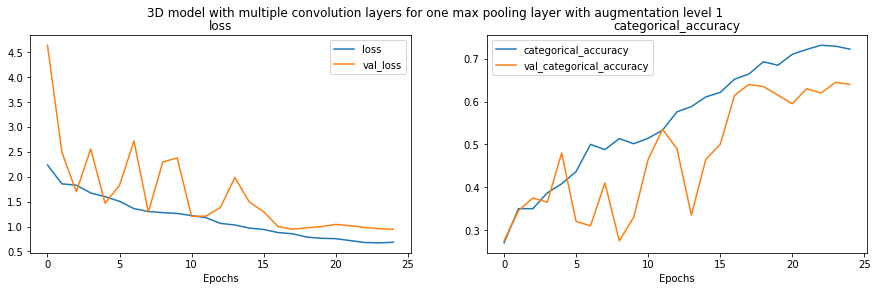

In [39]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Training accuracy is always below 75%.
* Validation accuracy is very low at 60%
* Validation accuracy and loss are unstable.
* This model will not be considered.

## 2D Models
2D Convolutional models standalone cannot process video images in a sequence manner like 3D model. So we need ``RNN (Recurrent Neural Network) - LSTM/GRU`` to process sequene image frames for image recognition. 

#### Convolutional 2D Model
* 2D convolutional layers take a three-dimensional input, typically an image with three color channels. They pass a filter, also called a convolution kernel, over the image, inspecting a small window of pixels at a time, for example 3×3 or 5×5 pixels in size, and moving the window until they have scanned the entire image. 
* The convolution operation calculates the dot product of the pixel values in the current filter window with the weights defined in the filter.

#### Long short-term memory (LSTM)
* LSTM is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate.
* An LSTM has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward. The differences are the operations within the LSTM's cells. These operations are used to allow the LSTM to keep or forget information.

#### Gated recurrent units (GRUs) 
* The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM. * The key difference between GRU and LSTM is that GRU's bag has two gates that are reset and update while LSTM has three gates that are input, output, forget. 
* GRU is less complex than LSTM because it has less number of gates. GRU exposes the complete memory and hidden layers but LSTM doesn't.

### Function to run 2D models

In [10]:
def run_2d_model(batch_size, frames, img_height, img_width, callbacks_list, mdl_fcn, optimizer,
               num_epochs = 15, dense_neurons = 64, rnn_cells = 128, dropout_val = 0.25, augment_level = 0, nworkers = 1):
    '''Construct and run a 2D model. Returns the 2D model after completion of fitting data.
    batch_size: Size of batch for training and validation
    frames: List of frame indices to be used by model
    img_height, img_width: Image dimensions for resizing
    callbacks_list: List of callbacks for model
    mdl_fcn: Model function to build 2D model. Must be one of 2D functions defined under "Models" class
    optimizer: Optimizer to be used by model
    num_epochs: Number of epochs by model
    dense_neurons: Number of dense neurons
    rnn_cells: Number of LSTM/GRU cells.
    dropout_val: Dropout value in 2D model
    augment_level: Augmentation level to be applied on generator. Must be one of {0,1,2}
    nworkers: Number of workers to be configured for fit_generator method.
    '''
    # Configuring trian and validation generator from get_generator function based on batch size and image properties.
    train_generator = Generator(project_folder, 'train', frames, batch_size, img_height, img_width, augment_level)
    val_generator = Generator(project_folder, 'val', frames, batch_size, img_height, img_width, augment_level)
    
    model = mdl_fcn(len(frames), img_height, img_width, optimizer, rnn_cells, dense_neurons = dense_neurons, 
                                                                        dropout_val = dropout_val, disp_summary=True)
    
    model.fit_generator(train_generator.generator(), steps_per_epoch=train_generator.steps, epochs=num_epochs, 
                        verbose=1, validation_data=val_generator.generator(), validation_steps=val_generator.steps, 
                        class_weight=None, workers=nworkers, initial_epoch=0, callbacks = callbacks_list)
    return model

### Model 6 - 2D Convolution model with RNN LSTM

In [12]:
def m2d_lstm(nframes, img_height, img_width, optimizer, rnn_cells = 64, dense_neurons = 64, dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model.
    The model would contain Four convolution layers  followed by a LSTM layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # second convolutional layer
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # third convolutional layer
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # fourth convolutional layer
    model.add(TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # flatten and put a fully connected layer
    model.add(TimeDistributed(Flatten()))

    # Declared LSTM layer for RNN model
    model.add(LSTM(rnn_cells))
    model.add(Dropout(dropout_val))

    # Declared fully connected layer
    model.add(Dense(dense_neurons, activation='relu')) 
    model.add(Dropout(dropout_val))

    # Defined softmax layer to classfify the model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment 12 -  2D Convolution model with RNN LSTM without augmentation

In [42]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,18)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Number of LSTM cells
lstm_cells = 256
# Title of the model
mdl_title = '2D convolution model with RNN LSTM without augmentation'

models[mdl_title] = run_2d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_lstm, optimizers.Adam(),
                                              num_epochs, dense_neurons = 256, 
                                              rnn_cells = lstm_cells, 
                                              dropout_val = 0.50, 
                                              augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

34/34 [==============================] - 39s 1s/step - loss: 0.2849 - categorical_accuracy: 0.9102 - val_loss: 0.6976 - val_categorical_accuracy: 0.7400

Epoch 00019: saving model to model_init_2021-02-0510_45_15.225478/model-00019-0.29157-0.90799-0.69757-0.74000.h5
Epoch 20/25
34/34 [==============================] - 39s 1s/step - loss: 0.2743 - categorical_accuracy: 0.9176 - val_loss: 0.7208 - val_categorical_accuracy: 0.7300

Epoch 00020: saving model to model_init_2021-02-0510_45_15.225478/model-00020-0.27827-0.91554-0.72084-0.73000.h5
Epoch 21/25
34/34 [==============================] - 39s 1s/step - loss: 0.2640 - categorical_accuracy: 0.9235 - val_loss: 0.7118 - val_categorical_accuracy: 0.7500

Epoch 00021: saving model to model_init_2021-02-0510_45_15.225478/model-00021-0.26769-0.92157-0.71183-0.75000.h5
Epoch 22/25
34/34 [==============================] - 39s 1s/step - loss: 0.2427 - categorical_accuracy: 0.9249 - val_loss: 0.7059 - val_categorical_accuracy: 0.7500

Epoch 000

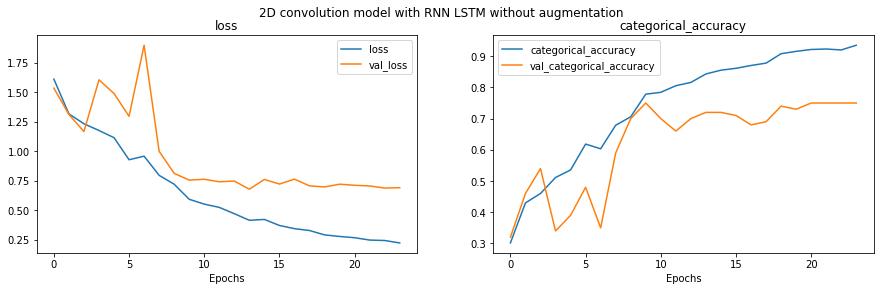

In [43]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Training accuracy is increasing after 10 epochs although validation accuracy remained flat.
* Training loss is decreasing continuously although validation loss remained flat after 10 epochs.
* This model will not be considered.

### Experiment 13 -  2D Convolution model with RNN LSTM with level 1 augmentation

In [13]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,18)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Number of LSTM cells
lstm_cells = 128
# Title of the model
mdl_title = '2D convolution model with RNN LSTM with level 1 augmentation'

models[mdl_title] = run_2d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_lstm, optimizers.Adam(),
                                              num_epochs, dense_neurons = 128, 
                                              rnn_cells = lstm_cells, 
                                              dropout_val = 0.25, 
                                              augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

34/34 [==============================] - 93s 3s/step - loss: 0.7050 - categorical_accuracy: 0.7252 - val_loss: 0.9740 - val_categorical_accuracy: 0.6450

Epoch 00019: saving model to model_init_2021-02-0511_34_03.922001/model-00019-0.71405-0.72247-0.97400-0.64500.h5
Epoch 20/25
34/34 [==============================] - 93s 3s/step - loss: 0.6785 - categorical_accuracy: 0.7425 - val_loss: 0.9771 - val_categorical_accuracy: 0.6500

Epoch 00020: saving model to model_init_2021-02-0511_34_03.922001/model-00020-0.68706-0.73605-0.97707-0.65000.h5
Epoch 21/25
34/34 [==============================] - 93s 3s/step - loss: 0.6507 - categorical_accuracy: 0.7550 - val_loss: 1.0117 - val_categorical_accuracy: 0.6400

Epoch 00021: saving model to model_init_2021-02-0511_34_03.922001/model-00021-0.65856-0.74887-1.01167-0.64000.h5
Epoch 22/25
34/34 [==============================] - 94s 3s/step - loss: 0.6396 - categorical_accuracy: 0.7487 - val_loss: 0.9808 - val_categorical_accuracy: 0.6250

Epoch 000

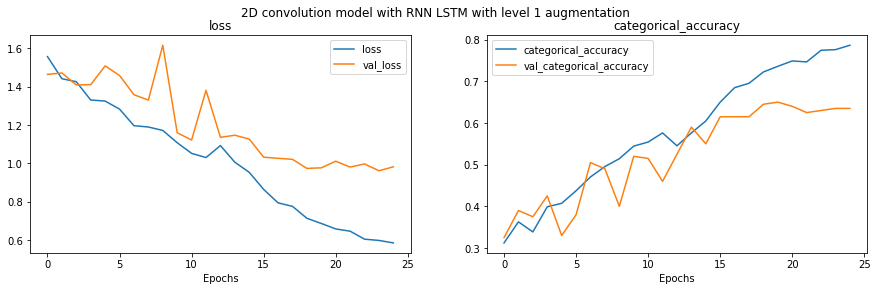

In [14]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Validation accuracy and loss are unstable
* Validation accuracy and loss tend to flat after 15 epochs
* Trianing Accuracy and Validation accuracy are low (below 80% and 60%)
* This model will not be considered.

### Model 7 - 2D Convolution model with RNN GRU

In [15]:
def m2d_gru(nframes, img_height, img_width, optimizer, rnn_cells = 64, dense_neurons = 64, dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model.
    The model would contain Four convolution layers  followed by a GRU layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # second convolutional layer
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # third convolutional layer
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # fourth convolutional layer
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # fifth convolutional layer
    model.add(TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # flatten and put a fully connected layer
    model.add(TimeDistributed(Flatten()))

    # Declared LSTM layer for RNN model
    model.add(GRU(rnn_cells))
    model.add(Dropout(dropout_val))

    # Declared fully connected layer
    model.add(Dense(dense_neurons, activation='relu')) 
    model.add(Dropout(dropout_val))

    # Defined softmax layer to classfify the model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment 14 -  2D Convolution model with RNN GRU without augmentation

In [16]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,18)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Number of GRU cells
gru_cells = 256
# Title of the model
mdl_title = '2D convolution model with RNN GRU without augmentation'

models[mdl_title] = run_2d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_gru, optimizers.Adam(),
                                              num_epochs, dense_neurons = 256, 
                                              rnn_cells = gru_cells, 
                                              dropout_val = 0.50, 
                                              augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

34/34 [==============================] - 38s 1s/step - loss: 0.1826 - categorical_accuracy: 0.9411 - val_loss: 0.5591 - val_categorical_accuracy: 0.7800

Epoch 00019: saving model to model_init_2021-02-0512_15_38.281914/model-00019-0.18216-0.93967-0.55913-0.78000.h5
Epoch 20/25
34/34 [==============================] - 38s 1s/step - loss: 0.1925 - categorical_accuracy: 0.9323 - val_loss: 0.6537 - val_categorical_accuracy: 0.7700

Epoch 00020: saving model to model_init_2021-02-0512_15_38.281914/model-00020-0.19660-0.93062-0.65374-0.77000.h5
Epoch 21/25
34/34 [==============================] - 38s 1s/step - loss: 0.1626 - categorical_accuracy: 0.9544 - val_loss: 0.6180 - val_categorical_accuracy: 0.7500

Epoch 00021: saving model to model_init_2021-02-0512_15_38.281914/model-00021-0.16618-0.95324-0.61803-0.75000.h5
Epoch 22/25
34/34 [==============================] - 38s 1s/step - loss: 0.1455 - categorical_accuracy: 0.9588 - val_loss: 0.6089 - val_categorical_accuracy: 0.7700

Epoch 000

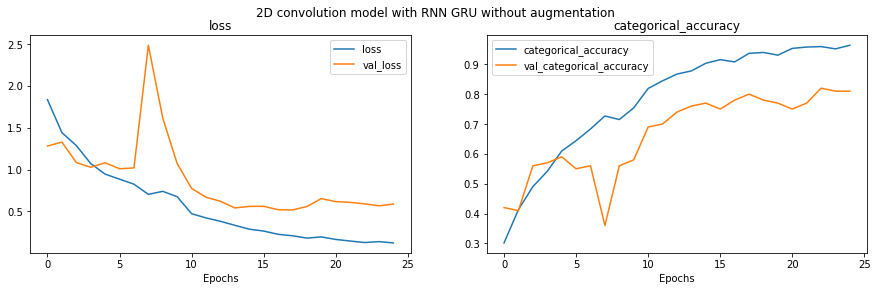

In [17]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Training accuracy and validation accuracy are increasing consistently
* Difference between training and validation accuracies is ~15% (96% - 81%)
* This model is a good candidate.
* This model may be improved by further tuning hyper parameters

### Experiment 15 -  2D Convolution model with RNN GRU with level 1 augmentation

In [18]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,18)).astype(int)
# Size of image in pixels
image_height, image_width = 120, 120
# Batch size used for training and validation
batch_size = 20
# Number of epochs to run.
num_epochs = 25
# Number of GRU cells
gru_cells = 128
# Title of the model
mdl_title = '2D convolution model with RNN GRU with level 1 augmentation'

models[mdl_title] = run_2d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_gru, optimizers.Adam(),
                                              num_epochs, dense_neurons = 128, 
                                              rnn_cells = gru_cells, 
                                              dropout_val = 0.25, 
                                              augment_level = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

34/34 [==============================] - 91s 3s/step - loss: 0.5194 - categorical_accuracy: 0.7929 - val_loss: 0.9206 - val_categorical_accuracy: 0.6700

Epoch 00019: saving model to model_init_2021-02-0512_32_00.397559/model-00019-0.51982-0.79186-0.92062-0.67000.h5
Epoch 20/25
34/34 [==============================] - 91s 3s/step - loss: 0.4980 - categorical_accuracy: 0.8028 - val_loss: 0.9445 - val_categorical_accuracy: 0.6500

Epoch 00020: saving model to model_init_2021-02-0512_32_00.397559/model-00020-0.49830-0.80618-0.94451-0.65000.h5
Epoch 21/25
34/34 [==============================] - 90s 3s/step - loss: 0.5208 - categorical_accuracy: 0.7892 - val_loss: 0.8903 - val_categorical_accuracy: 0.6900

Epoch 00021: saving model to model_init_2021-02-0512_32_00.397559/model-00021-0.52180-0.78808-0.89033-0.69000.h5
Epoch 22/25
34/34 [==============================] - 89s 3s/step - loss: 0.4957 - categorical_accuracy: 0.8017 - val_loss: 0.9019 - val_categorical_accuracy: 0.6550

Epoch 000

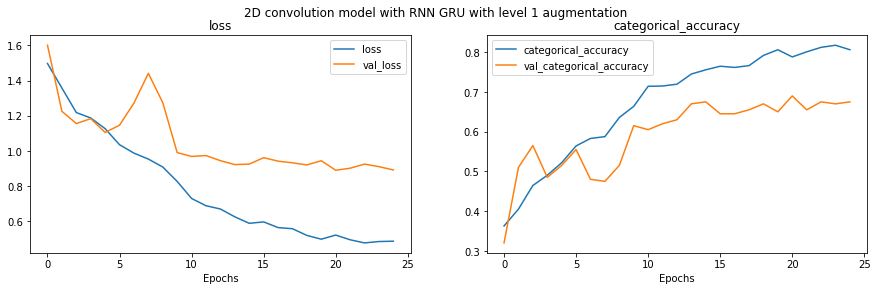

In [19]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Validation accuracy and loss tend to flat after 10 epochs
* Training Accuracy and Validation accuracy are low (below 80% and 65%)
* This model will not be considered.

## Transfer learning models
Importing the MobileNet model due to it's lightweight architecture and high speed performance as compared to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space in the nimblebox.ai platform.

### Model - Transfer Learning (MobileNet)
Transfer learning has the benefit of decreasing the training time for a neural network model and can result in lower generalization error.
- Transfer learning involves using models trained on one problem as a starting point on a related problem.
- Transfer learning is flexible, allowing the use of pre-trained models directly, as feature extraction preprocessing, and integrated into entirely new models. 
- Keras provides convenient access to many top performing models on the ImageNet image recognition tasks such as VGG, Inception, and ResNet.

Current case study, we are using MobileNet application for transfer learning.

In [20]:
# This mobilenet package is using for transfer learning
from keras.applications import mobilenet

### Defining function to run TL models

In [21]:
def run_tl_model(batch_size, frames, img_height, img_width, callbacks_list, mdl_fcn, optimizer, mobilenet_transfer,
               num_epochs = 15,  rnn_cells = 128, dense_neurons = 64, dropout_val = 0.25, augment_level = 0, nworkers = 1):
    '''Construct and run a 2D model with transfer learning. Returns the 2D model after completion of fitting data.
    batch_size: Size of batch for training and validation
    frames: List of frame indices to be used by model
    img_height, img_width: Image dimensions for resizing
    callbacks_list: List of callbacks for model
    mdl_fcn: Model function to build 2D model. Must be one of 2D functions defined under "Models" class
    optimizer: Optimizer to be used by model
    mobilenet_transfer: Model to use as base for transfer learning
    num_epochs: Number of epochs by model
    dense_neurons: Number of dense neurons
    rnn_cells: Number of LSTM/GRU cells.
    dropout_val: Dropout value in 2D model
    augment_level: Augmentation level to be applied on generator. Must be one of {0,1,2}
    nworkers: Number of workers to be configured for fit_generator method.
    '''
    # Configuring trian and validation generator from get_generator function based on batch size and image properties.
    train_generator = Generator(project_folder, 'train', frames, batch_size, img_height, img_width, augment_level)
    val_generator = Generator(project_folder, 'val', frames, batch_size, img_height, img_width, augment_level)
        
    model = mdl_fcn(len(frames), img_height, img_width, optimizer, mobilenet_transfer, rnn_cells, dense_neurons, 
                                                            dropout_val, True)
    
    model.fit_generator(train_generator.generator(), steps_per_epoch=train_generator.steps, epochs=num_epochs, 
                        verbose=1, validation_data=val_generator.generator(), validation_steps=val_generator.steps, 
                        class_weight=None, workers=nworkers, initial_epoch=0, callbacks = callbacks_list)
    
    return model

### Model 8 - 2D Transfer learning model with RNN LSTM

In [22]:
def m2d_tl_lstm(nframes, img_height, img_width, optimizer, mobilenet_transfer, rnn_cells=128, dense_neurons = 128, 
                                                                   dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model using transfer learning from mobilenet model.
    The model would contain Four convolution layers  followed by a LSTM layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))

    for layer in model.layers:
        layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(rnn_cells))
    model.add(Dropout(dropout_val))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout_val))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment 16 - 2D Transfer learning Model with RNN LSTM without augmentation

In [23]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 160, 160
# Batch size used for training and validation
batch_size = 5
# Number of epochs to run.
num_epochs = 20
# Number of LSTM cells
lstm_cells = 128
# Title of the model
mdl_title = '2D Transfer learning model with RNN LSTM without augmentation'
# Get pretrained imagenet weights with freezing top layers.
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

models[mdl_title] = run_tl_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_tl_lstm, optimizers.Adam(), mobilenet_transfer,
                                              num_epochs, rnn_cells = lstm_cells, dense_neurons = 128, 
                                              dropout_val = 0.25, augment_level = 0)

17227776/17225924 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 16, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_50 (TimeDis (None, 16, 5, 5, 1024)    4096      
_________________________________________________________________
time_distributed_51 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               2163200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (De

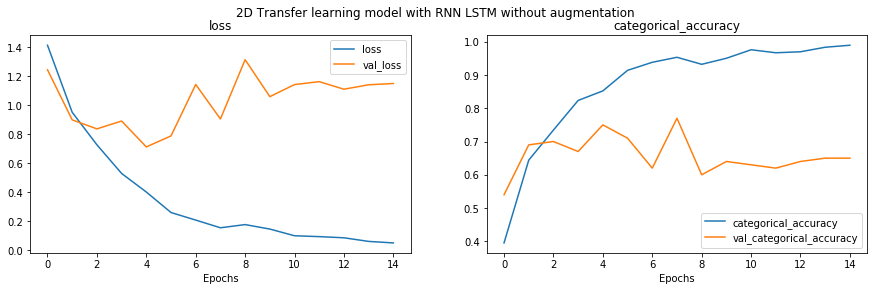

In [24]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Validation accuracy is not improving although training accuracy has improved.
* Validation loss and accuracy are unstable.
* Validation accuracy is low (~65%) to be considered.
* This model will not be considered.

### Model 9 - 2D Transfer learning model with RNN GRU

In [25]:
def m2d_tl_gru(nframes, img_height, img_width, optimizer, mobilenet_transfer, rnn_cells=128, dense_neurons = 128, 
                                                                   dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model using transfer learning from mobilenet model.
    The model would contain Four convolution layers  followed by a GRU layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(rnn_cells))
    model.add(Dropout(dropout_val))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout_val))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment 17 - 2D Transfer learning Model with RNN GRU without augmentation

In [26]:
# List of frames for training and validation of the model
frames = np.round(np.linspace(0,29,16)).astype(int)
# Size of image in pixels
image_height, image_width = 160, 160
# Batch size used for training and validation
batch_size = 5
# Number of epochs to run.
num_epochs = 20
# Number of GRU cells
gru_cells = 128
# Title of the model
mdl_title = '2D Transfer learning model with RNN GRU without augmentation'
# Get pretrained imagenet weights with freezing top layers.
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

models[mdl_title] = run_tl_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_tl_gru, optimizers.Adam(), mobilenet_transfer,
                                              num_epochs, rnn_cells = gru_cells, dense_neurons = 128, 
                                              dropout_val = 0.25, augment_level = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_53 (TimeDis (None, 16, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_54 (TimeDis (None, 16, 5, 5, 1024)    4096      
_________________________________________________________________
time_distributed_55 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               1622400   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

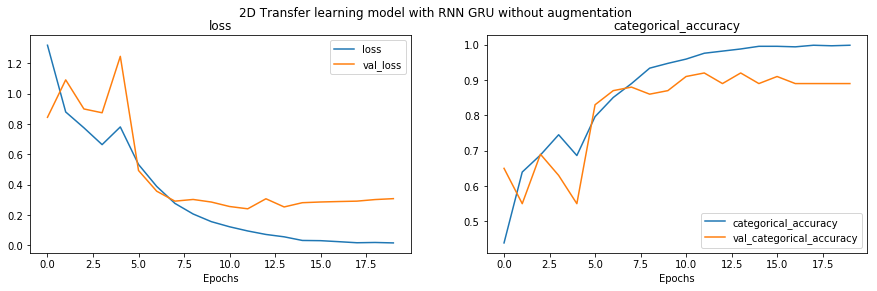

In [27]:
plot_metrics(models[mdl_title], title = mdl_title)

#### Observation:
* Both training accuracy and validation accuracy are stable.
* Validation accuracy is very good at 89%.
* Validation loss is also stable.
* This model will be considered.

## Conclusion

As per the standard recommendations, 3D Convolutional models, 2D Convolutional models and transfer learning models were built to classify frame sequence.

* Total 9 models are built and 17 experiments conducted with various hyper parameters.
 * 3D models - 5
 * 2D models - 2
 * Transfer Learning Models - 2
* 3D models are getting overfitted with basic parameters.
* In all experiments, augmentation shown **negative** impact on both trianing and validation accuracies.
 * When augmentation is applied, the image resolution is reduced due to out of memory errors using higher image resolutions.
* Good models from above analysis are:
 * 3D model with reduced filter size (2x2) gave 
   * Training Accuracy of ``96``% and ``81``% on Validation Accuracy.
   * Training Loss of ``0.11`` and ``0.54`` on Validation Loss.
   * Number of Parameters ``(4,121,909)`` less according to other models performance.
 * 2D model with GRU cells
   * Training Accuracy of ``96``% and ``81``% on Validation Accuracy.
   * Training Loss of ``0.12`` and ``0.58`` on Validation Loss.
   * Number of Parameters ``(2,428,517)`` less according to other models performance.
 * Transfer learning with GRU cells
   * Training Accuracy of ``99``% and ``89``% on Validation Accuracy.
   * Training Loss of ``0.01`` and ``0.30`` on Validation Loss
   * Number of Parameters ``(4,872,517)`` less according to other models performance.

### After doing all the experiments, we finalized Model 2 : 3D Model with multiple parameters, performed well.